## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print('✓ Libraries imported')

✓ Libraries imported


## 2. Load Dataset

In [2]:
df = pd.read_csv('../data/cybersecurity_large_synthesized_data.csv')
print(f'✓ Dataset loaded: {len(df):,} records')
print(f'\nColumns: {list(df.columns)}')

✓ Dataset loaded: 100,000 records

Columns: ['attack_type', 'target_system', 'outcome', 'timestamp', 'attacker_ip', 'target_ip', 'data_compromised_GB', 'attack_duration_min', 'security_tools_used', 'user_role', 'location', 'attack_severity', 'industry', 'response_time_min', 'mitigation_method']


## 3. Graph Construction Function

In [3]:
def build_graph(df, source_col, target_col, directed=True):
    """
    Build graph where edges connect values from source_col to target_col.
    If source_col == target_col, creates self-referential graph.
    """
    G = nx.DiGraph() if directed else nx.Graph()
    
    if source_col == target_col:
        # Self-referential: group by attacker_ip and create edges between feature values
        for ip, group in df.groupby('attacker_ip'):
            values = group[source_col].unique()
            for i, v1 in enumerate(values):
                for v2 in values[i+1:]:
                    if G.has_edge(v1, v2):
                        G[v1][v2]['weight'] += 1
                    else:
                        G.add_edge(v1, v2, weight=1)
    else:
        # Cross-feature: direct edge from source to target
        edge_counts = df.groupby([source_col, target_col]).size().reset_index(name='weight')
        for _, row in edge_counts.iterrows():
            G.add_edge(row[source_col], row[target_col], weight=row['weight'])
    
    return G

def graph_stats(G, name):
    """Print basic graph statistics."""
    print(f'\n{name}:')
    print(f'  Nodes: {G.number_of_nodes()}')
    print(f'  Edges: {G.number_of_edges()}')
    print(f'  Density: {nx.density(G):.4f}')
    if G.number_of_edges() > 0:
        avg_weight = np.mean([d['weight'] for u, v, d in G.edges(data=True)])
        print(f'  Avg edge weight: {avg_weight:.1f}')

print('✓ Functions defined')

✓ Functions defined


## 4. Build All Graphs

In [4]:
print('Building graphs...')

graphs = {}

# 1. Attack Type → Attack Type
graphs['attack_type_to_attack_type'] = build_graph(df, 'attack_type', 'attack_type', directed=False)
graph_stats(graphs['attack_type_to_attack_type'], 'Attack Type → Attack Type')

# 2. Attack Type → Industry
graphs['attack_type_to_industry'] = build_graph(df, 'attack_type', 'industry')
graph_stats(graphs['attack_type_to_industry'], 'Attack Type → Industry')

# 3. Attack Type → Target System
graphs['attack_type_to_target_system'] = build_graph(df, 'attack_type', 'target_system')
graph_stats(graphs['attack_type_to_target_system'], 'Attack Type → Target System')

# 4. Industry → Industry
graphs['industry_to_industry'] = build_graph(df, 'industry', 'industry', directed=False)
graph_stats(graphs['industry_to_industry'], 'Industry → Industry')

# 5. Target System → Target System
graphs['target_system_to_target_system'] = build_graph(df, 'target_system', 'target_system', directed=False)
graph_stats(graphs['target_system_to_target_system'], 'Target System → Target System')

# 6. User Role → Industry
graphs['user_role_to_industry'] = build_graph(df, 'user_role', 'industry')
graph_stats(graphs['user_role_to_industry'], 'User Role → Industry')

# 7. Mitigation Method → Attack Type
graphs['mitigation_to_attack_type'] = build_graph(df, 'mitigation_method', 'attack_type')
graph_stats(graphs['mitigation_to_attack_type'], 'Mitigation Method → Attack Type')

# 8. Security Tools → Outcome
graphs['security_tools_to_outcome'] = build_graph(df, 'security_tools_used', 'outcome')
graph_stats(graphs['security_tools_to_outcome'], 'Security Tools → Outcome')

print(f'\n✓ Built {len(graphs)} graphs')

Building graphs...

Attack Type → Attack Type:
  Nodes: 0
  Edges: 0
  Density: 0.0000

Attack Type → Industry:
  Nodes: 16
  Edges: 64
  Density: 0.2667
  Avg edge weight: 1562.5

Attack Type → Target System:
  Nodes: 16
  Edges: 64
  Density: 0.2667
  Avg edge weight: 1562.5

Attack Type → Attack Type:
  Nodes: 0
  Edges: 0
  Density: 0.0000

Attack Type → Industry:
  Nodes: 16
  Edges: 64
  Density: 0.2667
  Avg edge weight: 1562.5

Attack Type → Target System:
  Nodes: 16
  Edges: 64
  Density: 0.2667
  Avg edge weight: 1562.5

Industry → Industry:
  Nodes: 0
  Edges: 0
  Density: 0.0000

Industry → Industry:
  Nodes: 0
  Edges: 0
  Density: 0.0000

Target System → Target System:
  Nodes: 0
  Edges: 0
  Density: 0.0000

User Role → Industry:
  Nodes: 12
  Edges: 32
  Density: 0.2424
  Avg edge weight: 3125.0

Mitigation Method → Attack Type:
  Nodes: 13
  Edges: 40
  Density: 0.2564
  Avg edge weight: 2500.0

Security Tools → Outcome:
  Nodes: 10
  Edges: 16
  Density: 0.1778
  Avg

## 5. Visualize Graphs

Visualizing graphs...
Skipping Attack → Type → To → Attack → Type: empty graph


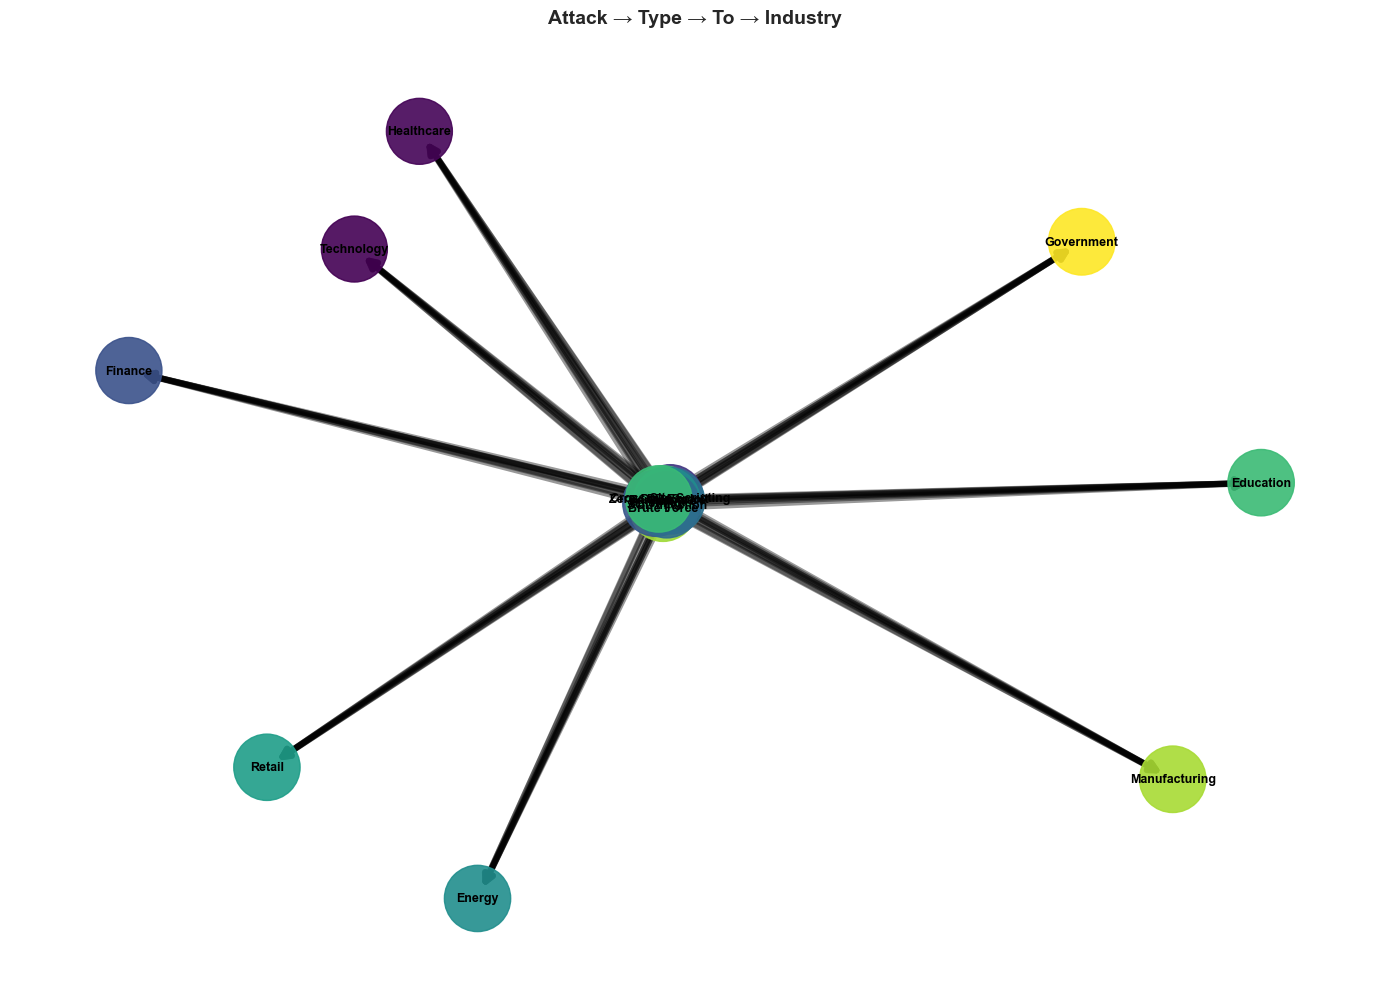

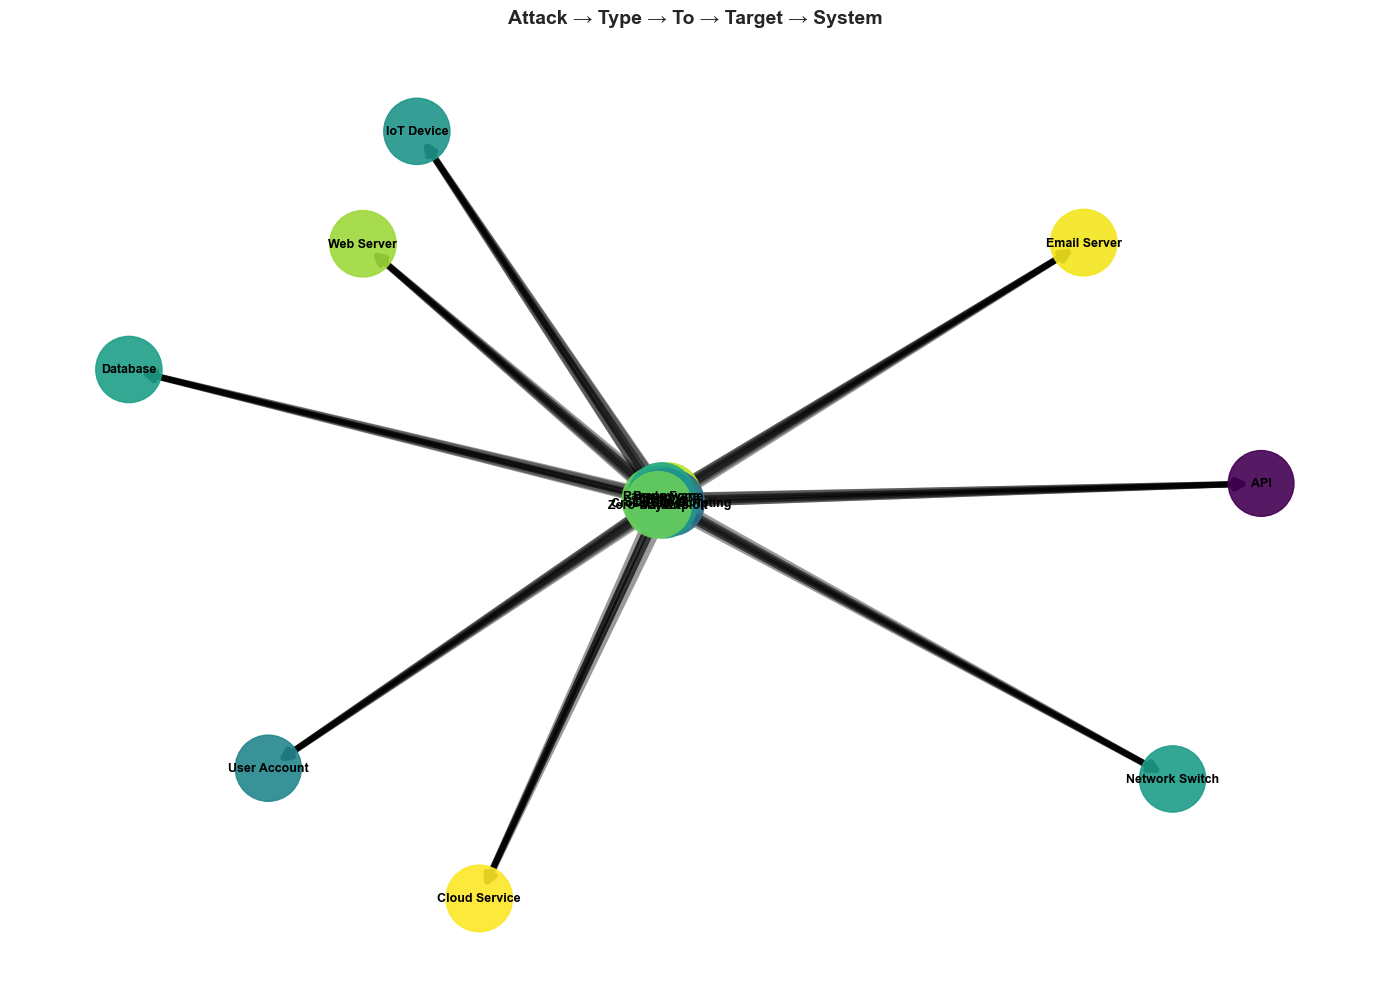

Skipping Industry → To → Industry: empty graph
Skipping Target → System → To → Target → System: empty graph


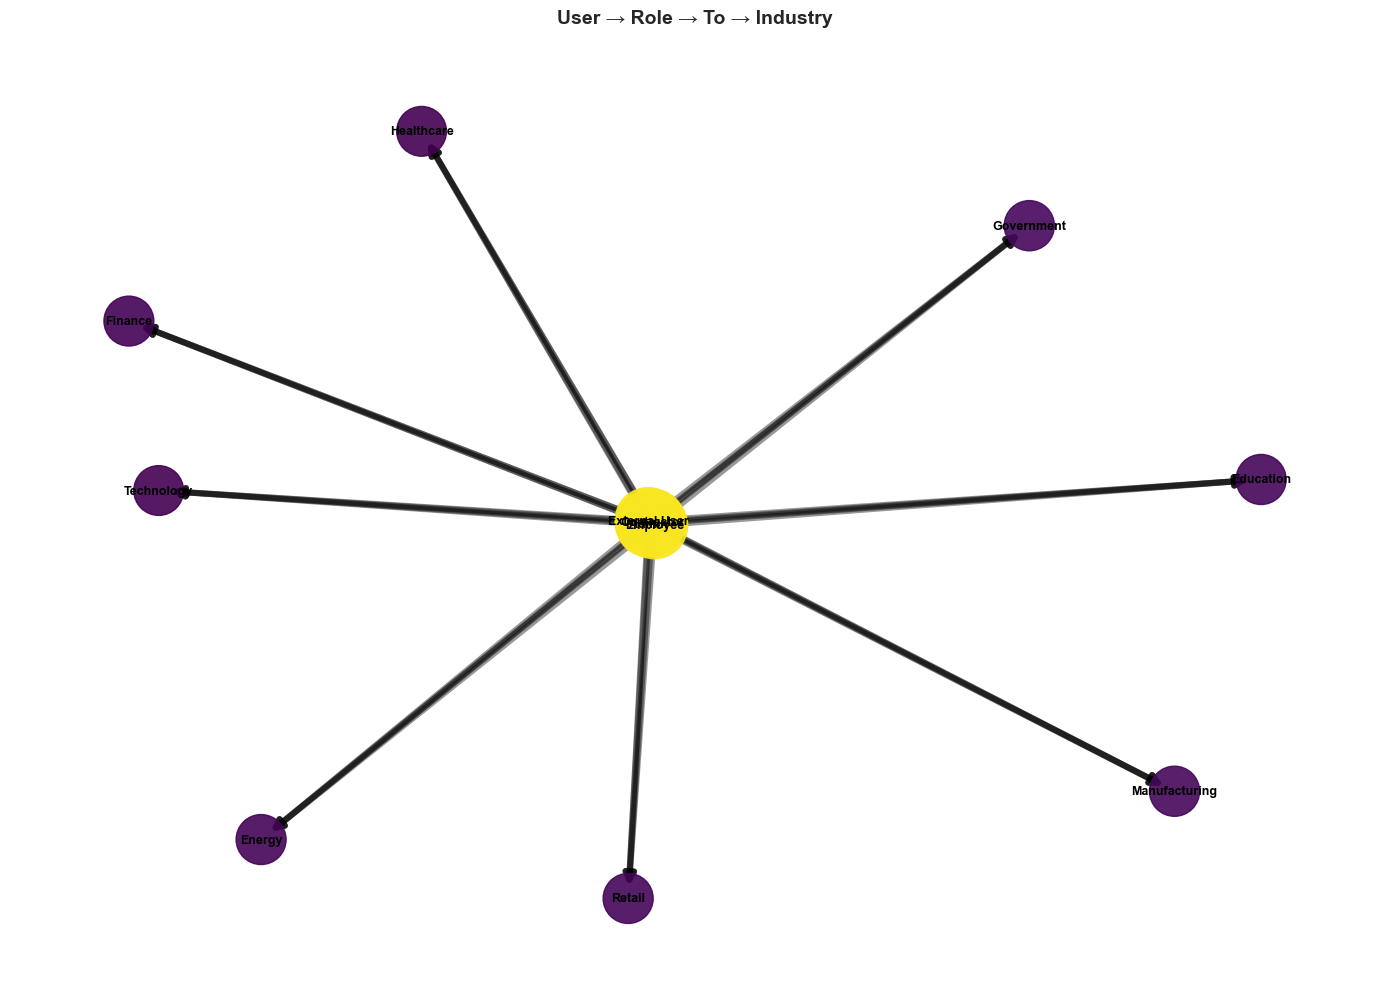

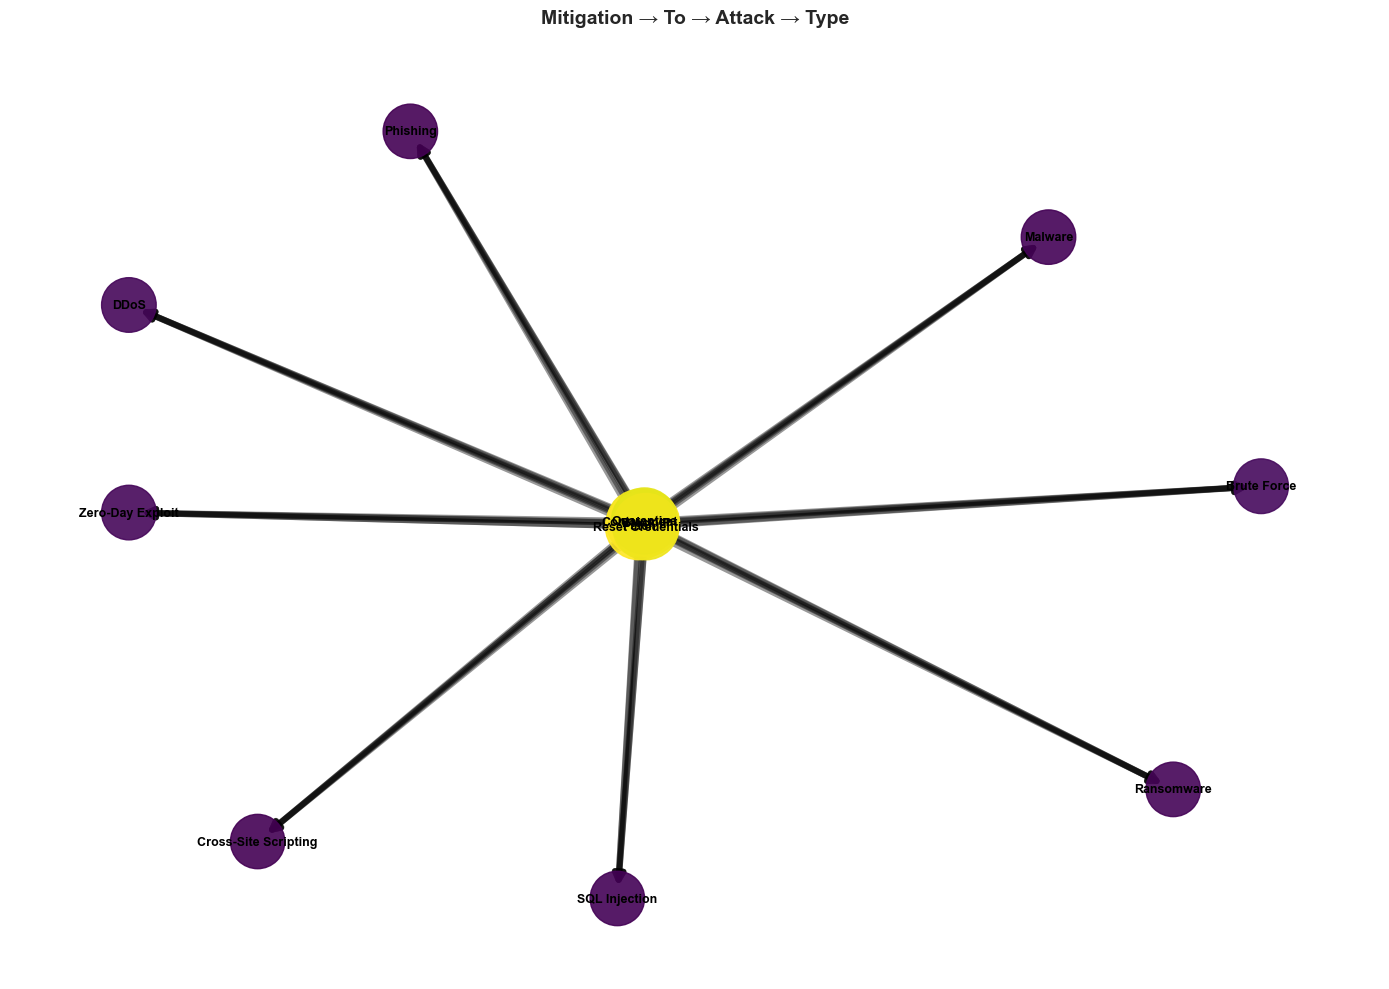

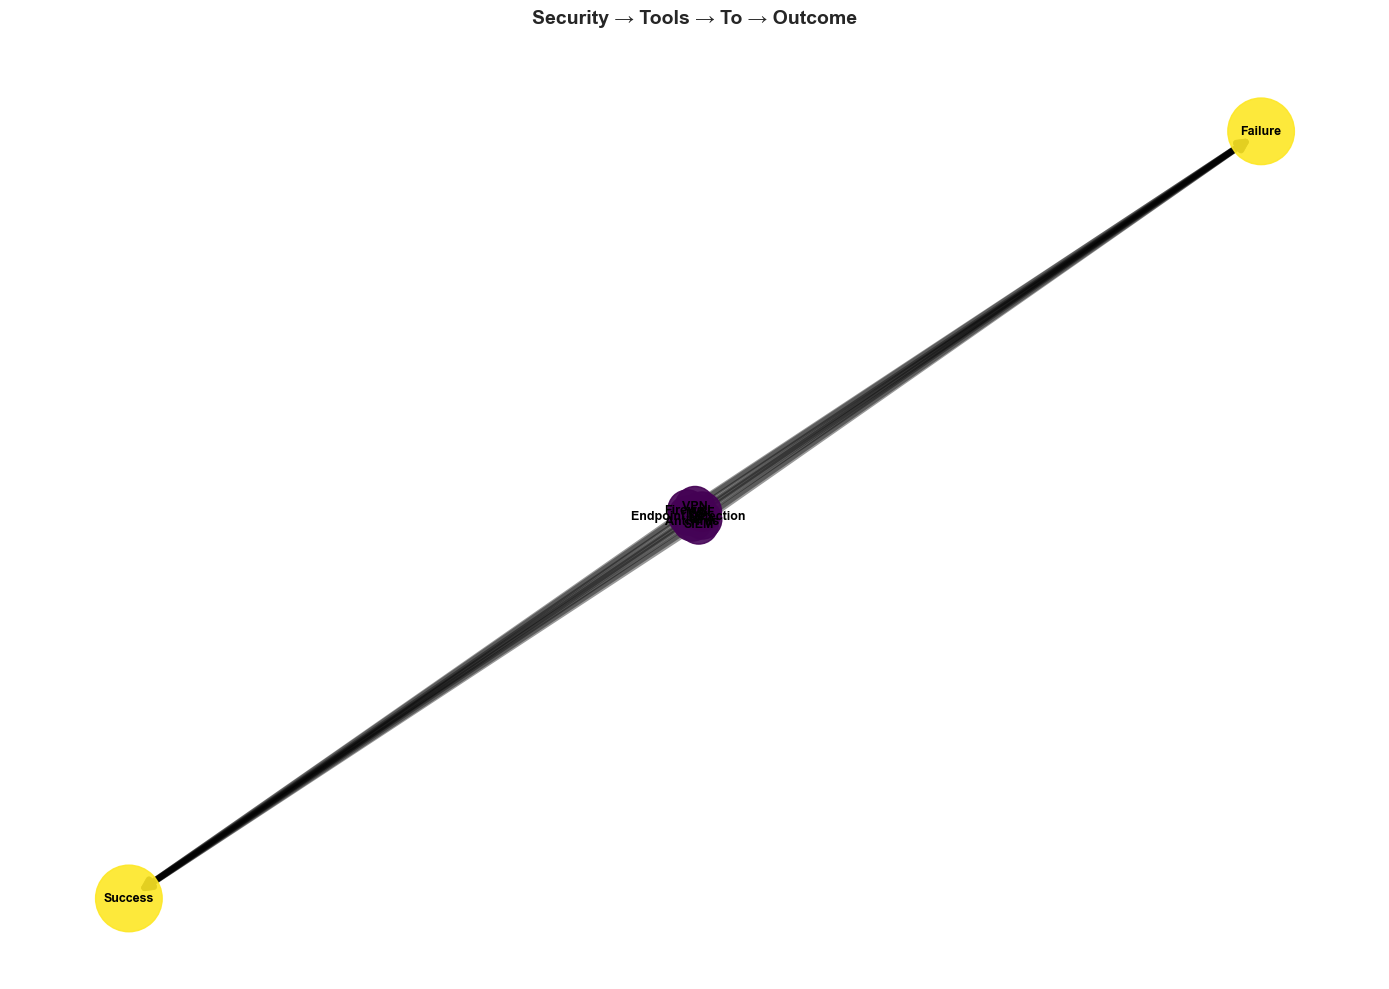

✓ Visualization complete


In [5]:
def visualize_graph(G, title, figsize=(14, 10)):
    """Visualize a graph with weighted edges."""
    if G.number_of_nodes() == 0:
        print(f'Skipping {title}: empty graph')
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42, weight='weight')
    
    # Node sizes based on degree
    degrees = dict(G.degree(weight='weight'))
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [300 + (degrees[n] / max_degree) * 2000 for n in G.nodes()]
    
    # Edge widths based on weight
    edges = list(G.edges(data=True))
    weights = [d['weight'] for u, v, d in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [0.5 + (w / max_weight) * 4 for w in weights]
    
    # Draw
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, 
                          arrows=G.is_directed(), arrowsize=15, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color=list(degrees.values()), 
                          cmap=plt.cm.viridis, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print('Visualizing graphs...')

for name, G in graphs.items():
    visualize_graph(G, name.replace('_', ' → ').title())

print('✓ Visualization complete')

## 6. Top Connections per Graph

In [10]:
print('Top 10 strongest connections per graph:\n')

for name, G in graphs.items():
    print(f'\n{name.replace("_", " → ").upper()}:')
    edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)[:10]
    
    for u, v, w in edges_sorted:
        arrow = '→' if G.is_directed() else '↔'
        print(f'  {u} {arrow} {v}: {w:.0f}')

Top 10 strongest connections per graph:


ATTACK → TYPE → TO → ATTACK → TYPE:

ATTACK → TYPE → TO → INDUSTRY:
  Brute Force → Manufacturing: 1650
  Brute Force → Retail: 1645
  DDoS → Government: 1633
  Ransomware → Education: 1630
  Cross-Site Scripting → Government: 1619
  Zero-Day Exploit → Finance: 1619
  Zero-Day Exploit → Government: 1614
  Malware → Government: 1602
  Phishing → Healthcare: 1597
  SQL Injection → Education: 1597

ATTACK → TYPE → TO → TARGET → SYSTEM:
  Cross-Site Scripting → Cloud Service: 1656
  Cross-Site Scripting → Email Server: 1637
  DDoS → Web Server: 1637
  Brute Force → Email Server: 1634
  Phishing → Email Server: 1627
  Zero-Day Exploit → IoT Device: 1617
  Phishing → Cloud Service: 1613
  Zero-Day Exploit → Cloud Service: 1607
  Malware → Network Switch: 1600
  Zero-Day Exploit → Network Switch: 1598

INDUSTRY → TO → INDUSTRY:

TARGET → SYSTEM → TO → TARGET → SYSTEM:

USER → ROLE → TO → INDUSTRY:
  Employee → Education: 3215
  Contractor → Government

## 7. Centrality Analysis per Graph

In [7]:
print('Centrality analysis per graph:\n')

centrality_results = {}

for name, G in graphs.items():
    if G.number_of_nodes() == 0:
        continue
    
    print(f'\n{name.replace("_", " → ").upper()}:')
    
    # Degree centrality
    degree_cent = nx.degree_centrality(G)
    top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print('  Top 5 by degree centrality:')
    for node, cent in top_degree:
        print(f'    {node}: {cent:.4f}')
    
    centrality_results[name] = {'degree': degree_cent}

print('\n✓ Centrality analysis complete')

Centrality analysis per graph:


ATTACK → TYPE → TO → INDUSTRY:
  Top 5 by degree centrality:
    Brute Force: 0.5333
    Education: 0.5333
    Energy: 0.5333
    Finance: 0.5333
    Government: 0.5333

ATTACK → TYPE → TO → TARGET → SYSTEM:
  Top 5 by degree centrality:
    Brute Force: 0.5333
    API: 0.5333
    Cloud Service: 0.5333
    Database: 0.5333
    Email Server: 0.5333

USER → ROLE → TO → INDUSTRY:
  Top 5 by degree centrality:
    Admin: 0.7273
    Contractor: 0.7273
    Employee: 0.7273
    External User: 0.7273
    Education: 0.3636

MITIGATION → TO → ATTACK → TYPE:
  Top 5 by degree centrality:
    Block IP: 0.6667
    Containment: 0.6667
    Patch: 0.6667
    Quarantine: 0.6667
    Reset Credentials: 0.6667

SECURITY → TOOLS → TO → OUTCOME:
  Top 5 by degree centrality:
    Failure: 0.8889
    Success: 0.8889
    Antivirus: 0.2222
    Endpoint Detection: 0.2222
    Firewall: 0.2222

✓ Centrality analysis complete


## 8. Save All Graphs

In [8]:
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

print('Saving graphs to models/ directory...\n')

for name, G in graphs.items():
    # Save as GML
    gml_path = f'../models/{name}.gml'
    nx.write_gml(G, gml_path)
    print(f'✓ Saved {gml_path}')
    
    # Save edge list as CSV
    edge_data = []
    for u, v, d in G.edges(data=True):
        edge_data.append({'source': u, 'target': v, 'weight': d['weight']})
    
    if edge_data:
        edge_df = pd.DataFrame(edge_data)
        csv_path = f'../models/{name}_edges.csv'
        edge_df.to_csv(csv_path, index=False)
        print(f'✓ Saved {csv_path}')

print(f'\n✓ All {len(graphs)} graphs saved to models/')

Saving graphs to models/ directory...

✓ Saved ../models/attack_type_to_attack_type.gml
✓ Saved ../models/attack_type_to_industry.gml
✓ Saved ../models/attack_type_to_industry_edges.csv
✓ Saved ../models/attack_type_to_target_system.gml
✓ Saved ../models/attack_type_to_target_system_edges.csv
✓ Saved ../models/industry_to_industry.gml
✓ Saved ../models/target_system_to_target_system.gml
✓ Saved ../models/user_role_to_industry.gml
✓ Saved ../models/user_role_to_industry_edges.csv
✓ Saved ../models/mitigation_to_attack_type.gml
✓ Saved ../models/mitigation_to_attack_type_edges.csv
✓ Saved ../models/security_tools_to_outcome.gml
✓ Saved ../models/security_tools_to_outcome_edges.csv

✓ All 8 graphs saved to models/
✓ Saved ../models/attack_type_to_attack_type.gml
✓ Saved ../models/attack_type_to_industry.gml
✓ Saved ../models/attack_type_to_industry_edges.csv
✓ Saved ../models/attack_type_to_target_system.gml
✓ Saved ../models/attack_type_to_target_system_edges.csv
✓ Saved ../models/indust

## 9. Summary Report

In [9]:
print('\n' + '='*70)
print('FEATURE-BASED GRAPH ANALYSIS SUMMARY')
print('='*70)

print(f'\nTotal graphs created: {len(graphs)}')

summary_data = []
for name, G in graphs.items():
    summary_data.append({
        'Graph': name.replace('_', ' → ').title(),
        'Nodes': G.number_of_nodes(),
        'Edges': G.number_of_edges(),
        'Density': f'{nx.density(G):.4f}',
        'Type': 'Directed' if G.is_directed() else 'Undirected'
    })

summary_df = pd.DataFrame(summary_data)
print('\n' + summary_df.to_string(index=False))

print('\n' + '='*70)
print('✓ Analysis complete! All graphs saved to models/')
print('='*70)


FEATURE-BASED GRAPH ANALYSIS SUMMARY

Total graphs created: 8

                                 Graph  Nodes  Edges Density       Type
    Attack → Type → To → Attack → Type      0      0  0.0000 Undirected
         Attack → Type → To → Industry     16     64  0.2667   Directed
  Attack → Type → To → Target → System     16     64  0.2667   Directed
              Industry → To → Industry      0      0  0.0000 Undirected
Target → System → To → Target → System      0      0  0.0000 Undirected
           User → Role → To → Industry     12     32  0.2424   Directed
       Mitigation → To → Attack → Type     13     40  0.2564   Directed
       Security → Tools → To → Outcome     10     16  0.1778   Directed

✓ Analysis complete! All graphs saved to models/
